# Programa original

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
# %matplotlib inline
import nltk
nltk.download('stopwords')


from subprocess import check_output

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('Sentiment.csv')
data = data[['text','sentiment']]

train, test = train_test_split(data,test_size = 0.1)

train = train[train.sentiment != "Neutral"]

train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

In [ ]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Positive words


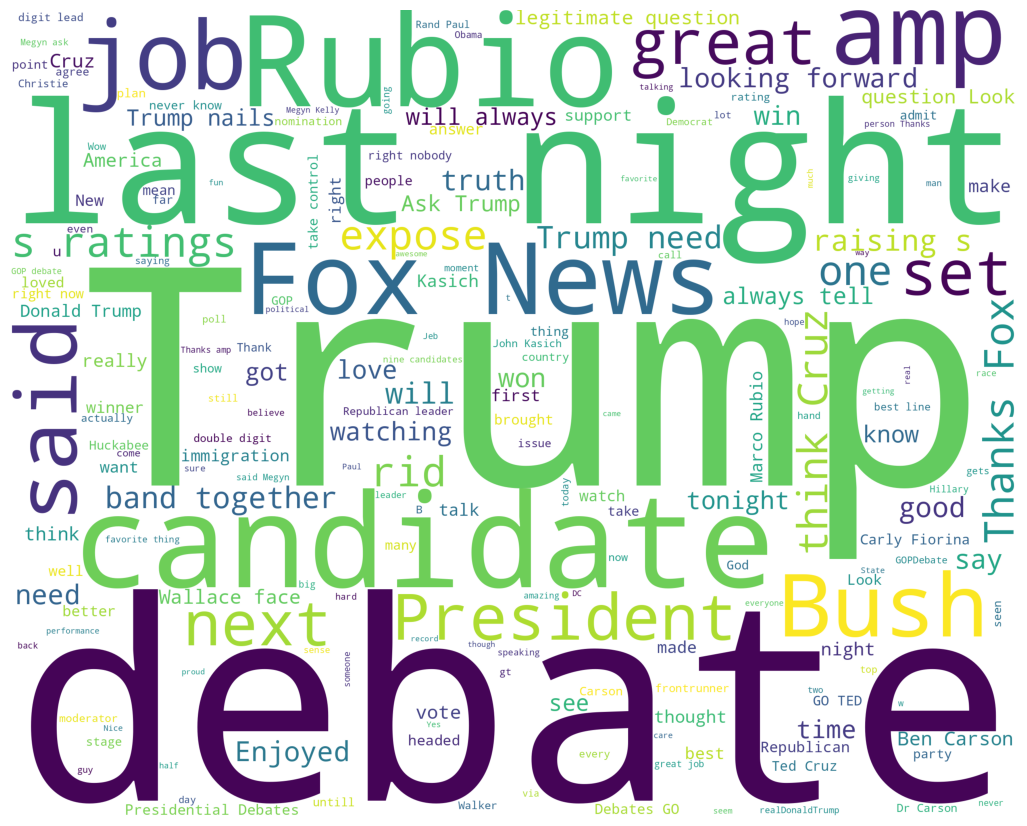

Negative words


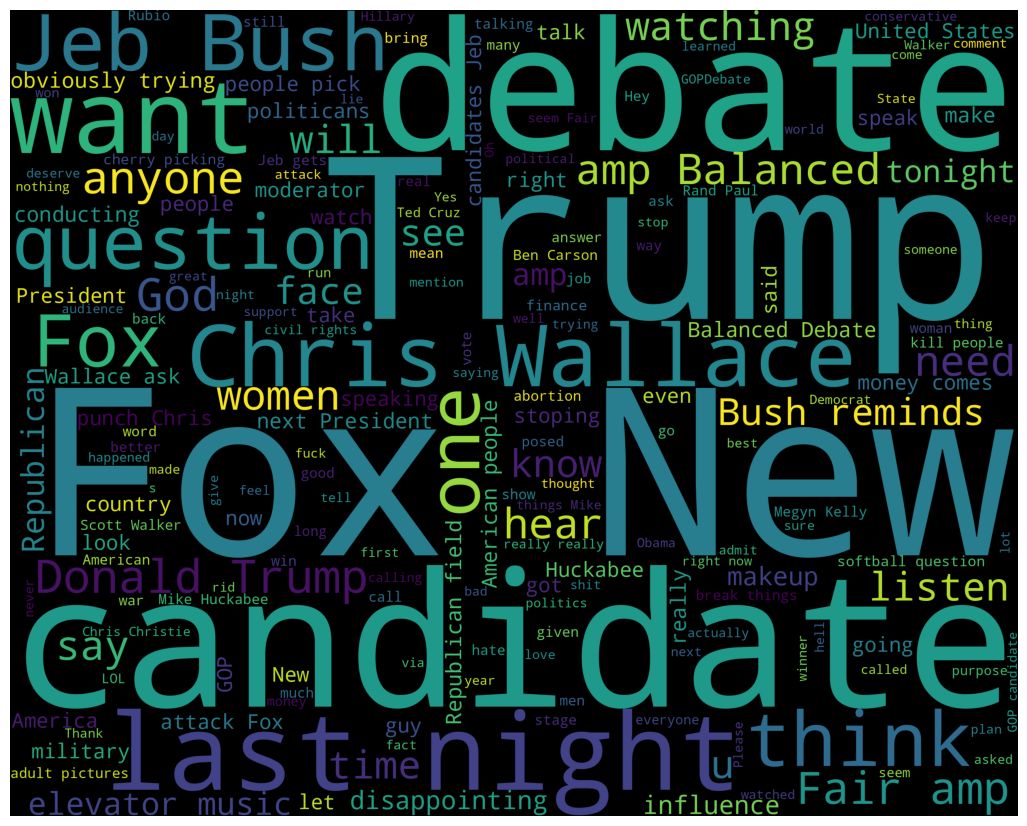

In [ ]:
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [ ]:
tweets = []
stopwords_set = set(stopwords.words("english"))

In [ ]:
for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_cleaned,row.sentiment))

test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

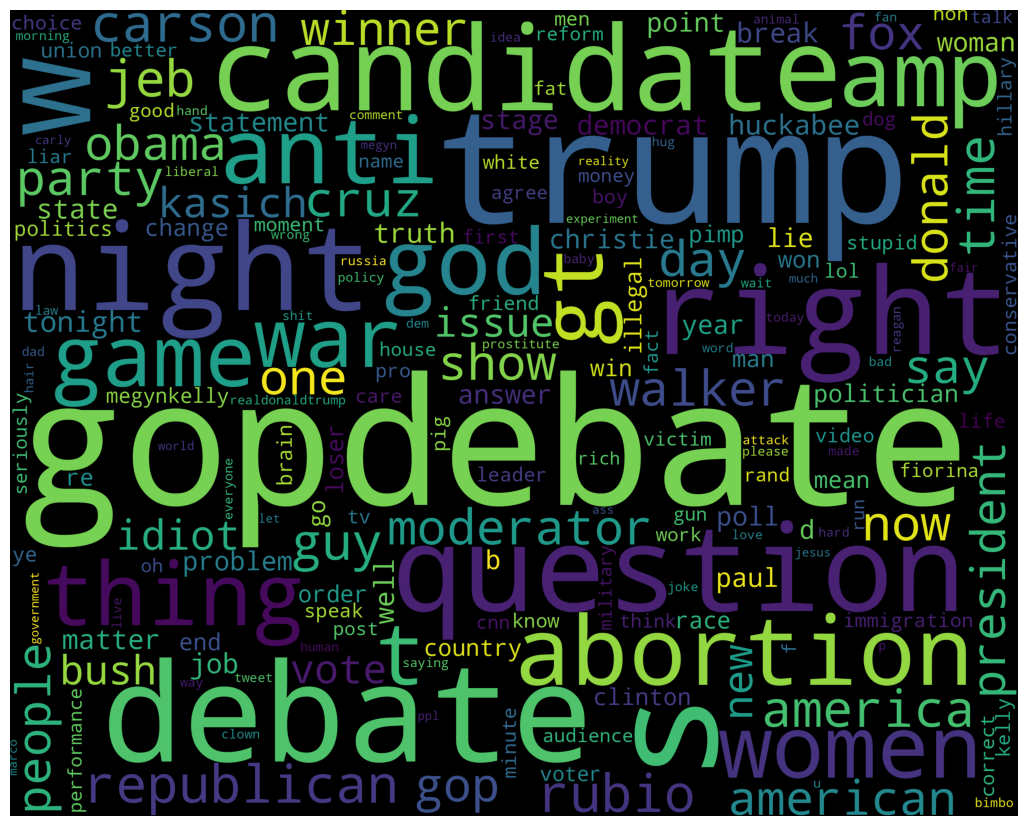

In [ ]:
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['containts(%s)' % word] = (word in document_words)
    return features

wordcloud_draw(w_features)

In [ ]:
training_set = nltk.classify.apply_features(extract_features,tweets)
len(training_set)

9630

In [ ]:
len(training_set[0][0])

14749

In [ ]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [ ]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg:
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'):
        neg_cnt = neg_cnt + 1
for obj in test_pos:
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'):
        pos_cnt = pos_cnt + 1

print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))

[Negative]: 846/803 
[Positive]: 229/91 


In [ ]:
correct = 0
total = 0
for index, row in test.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
                     if 'http' not in word
                     and not word.startswith('@')
                     and not word.startswith('#')
                     and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    prediction = classifier.classify(extract_features(words_without_stopwords))
    if prediction == row.sentiment:
        correct += 1
    total += 1

accuracy = correct / total
print("Accuracy:", accuracy)

Accuracy: 0.6476945244956772


# Implementacion con TF-IDF

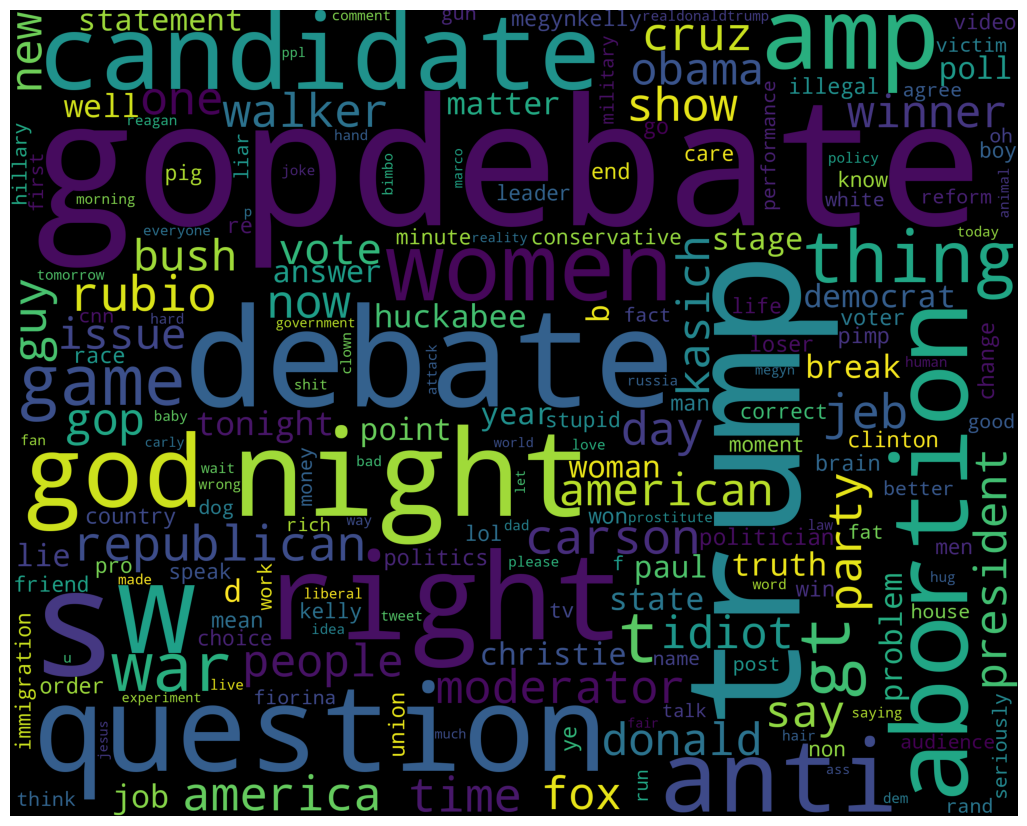

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

def extract_features_tfidf_pca(tweet):
    text, sentiment = tweet
    text = ' '.join(text)
    features = tfidf_vectorizer.fit_transform([text])
    features_list = features.toarray()[0]

    return {'tfidf': features_list, 'sentiment': sentiment}

w_featurest = get_word_features(get_words_in_tweets(tweets))
wordcloud_draw(w_features)

In [ ]:
def transform_to_word_features(features_dict):
    tfidf_features = features_dict['tfidf']
    word_indices = [i for i, tfidf_value in enumerate(tfidf_features) if tfidf_value > 0]
    words = tfidf_vectorizer.get_feature_names_out()
    word_features = {'contains({})'.format(words[i]): tfidf_features[i] for i in word_indices if i < len(words)}
    word_features['sentiment'] = features_dict['sentiment']

    return word_features

training_set_tfidf = [extract_features_tfidf_pca(tweet) for tweet in tweets]
training_set_word_features = [transform_to_word_features(features_dict) for features_dict in training_set_tfidf]

In [ ]:
training_set_word_features_tuples = [(features_dict, features_dict['sentiment']) for features_dict in training_set_word_features]

#len(training_set_tfidf[0]['tfidf'])
training_set_word_features_tuples[0]
# Se reduce la dimensionalidad solo con 11 caracteristicas

({'contains(2016)': 0.4082482904638631,
  'contains(amp)': 0.4082482904638631,
  'contains(brilliant)': 0.4082482904638631,
  'contains(calm)': 0.4082482904638631,
  'contains(collected)': 0.4082482904638631,
  'contains(cool)': 0.4082482904638631,
  'sentiment': 'Negative'},
 'Negative')

In [ ]:
# Entrena el clasificador Naive Bayes
classifier3 = nltk.NaiveBayesClassifier.train(training_set_word_features_tuples)

In [ ]:
len(test_neg)

846

In [ ]:
test_tweets = []
for index, row in test.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    test_tweets.append((words_cleaned,row.sentiment))
test_tweets[0]

(['went',
  'bed',
  'speechless',
  'after',
  'woke',
  'pissd',
  'off',
  'with',
  'how',
  'went',
  'about',
  'attacking'],
 'Positive')

In [ ]:
test_set_tfidf = [extract_features_tfidf_pca(tweet) for tweet in test_tweets]
test_set_word_features = [transform_to_word_features(features_dict) for features_dict in test_set_tfidf]
test_set_word_features_tuples = [(features_dict, features_dict['sentiment']) for features_dict in test_set_word_features]
test_set_word_features[0]

{'contains(about)': 0.2672612419124244,
 'contains(amp)': 0.2672612419124244,
 'contains(clinton)': 0.2672612419124244,
 'contains(debate)': 0.2672612419124244,
 'contains(dems)': 0.2672612419124244,
 'contains(hillary)': 0.2672612419124244,
 'contains(liberal)': 0.2672612419124244,
 'contains(should)': 0.2672612419124244,
 'contains(this)': 0.5345224838248488,
 'sentiment': 'Positive'}

In [ ]:
neg_cnt = 0
pos_cnt = 0
test_pos = [test_set for test_set in test_set_word_features if test_set.get('sentiment') == 'Positive']

test_neg = [test_set for test_set in test_set_word_features if test_set.get('sentiment') == 'Negative']

for obj in test_neg:
    res =  classifier3.classify(obj)
    if(res == 'Negative'):
        neg_cnt = neg_cnt + 1
for obj in test_pos:
    res =  classifier3.classify(obj)
    if(res == 'Positive'):
        pos_cnt = pos_cnt + 1

print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))

[Negative]: 857/857 
[Positive]: 242/242 


In [ ]:
correct = 0
total = 0
neg = 0
pos = 0
for test in test_set_word_features:
    prediction = classifier3.classify(test)
    if prediction == test['sentiment']:
        if prediction == 'Negative':
          neg = neg + 1
        if prediction == 'Positive':
          pos = pos + 1
        correct += 1
    total += 1

accuracy = correct / total
print("Accuracy:", accuracy)

Accuracy: 0.7917867435158501


# Modificacion de set de entrenamiento y prueba

In [ ]:
data = pd.read_csv('Sentiment.csv')
data = data[['text','sentiment']]

train, test = train_test_split(data,test_size = 0.2)

train = train[train.sentiment != "Neutral"]

train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

In [ ]:
tweets = []
for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_cleaned,row.sentiment))

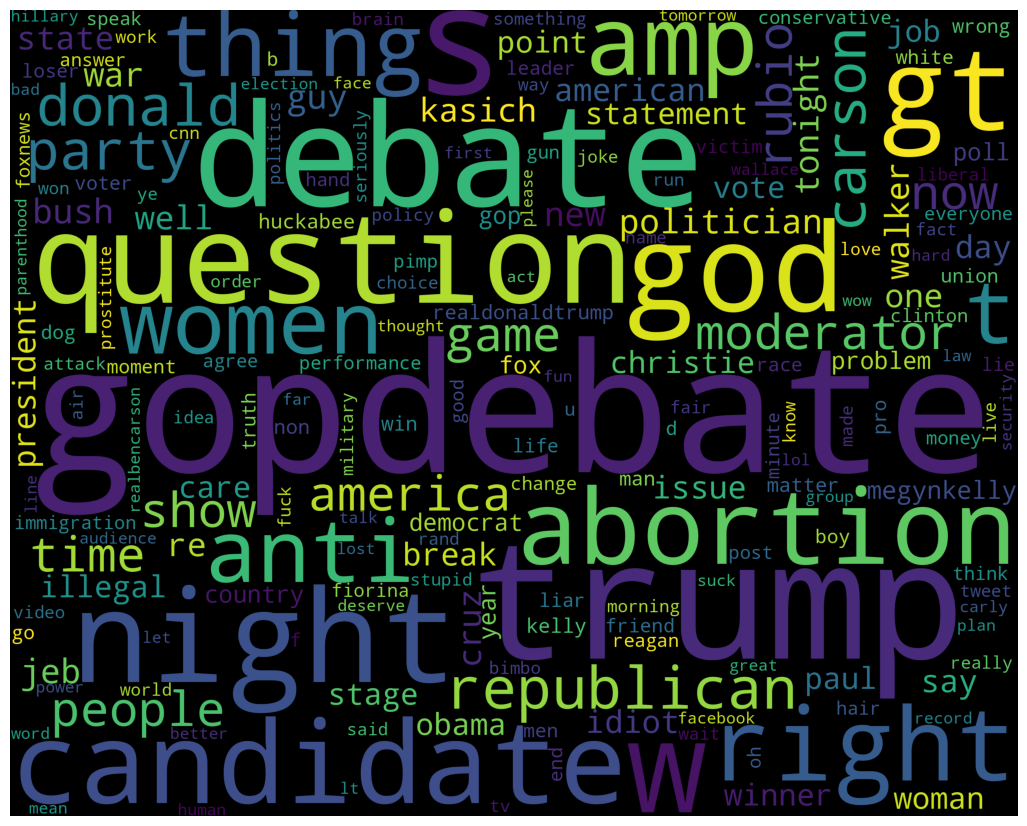

In [ ]:
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))
wordcloud_draw(w_features)

In [ ]:
training_set_tfidf = [extract_features_tfidf_pca(tweet) for tweet in tweets]
training_set_word_features = [transform_to_word_features(features_dict) for features_dict in training_set_tfidf]
training_set_word_features_tuples = [(features_dict, features_dict['sentiment']) for features_dict in training_set_word_features]
training_set_word_features_tuples[0]

({'contains(chance)': 0.35355339059327373,
  'contains(considering)': 0.35355339059327373,
  'contains(doesn)': 0.35355339059327373,
  'contains(have)': 0.35355339059327373,
  'contains(hell)': 0.35355339059327373,
  'contains(interesting)': 0.35355339059327373,
  'contains(snowball)': 0.35355339059327373,
  'contains(winni)': 0.35355339059327373,
  'sentiment': 'Negative'},
 'Negative')

In [ ]:
classifier4 = nltk.NaiveBayesClassifier.train(training_set_word_features_tuples)

In [ ]:
test_tweets = []
for index, row in test.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    test_tweets.append((words_cleaned,row.sentiment))
test_set_tfidf = [extract_features_tfidf_pca(tweet) for tweet in test_tweets]
test_set_word_features = [transform_to_word_features(features_dict) for features_dict in test_set_tfidf]
test_set_word_features_tuples = [(features_dict, features_dict['sentiment']) for features_dict in test_set_word_features]
test_set_word_features[0]

{'contains(all)': 0.2672612419124244,
 'contains(chief)': 0.2672612419124244,
 'contains(commander)': 0.2672612419124244,
 'contains(completely)': 0.2672612419124244,
 'contains(cruz)': 0.2672612419124244,
 'contains(embarrassingly)': 0.5345224838248488,
 'contains(him)': 0.2672612419124244,
 'contains(in)': 0.2672612419124244,
 'contains(insurgency)': 0.2672612419124244,
 'contains(kill)': 0.2672612419124244,
 'contains(makes)': 0.2672612419124244,
 'sentiment': 'Negative'}

In [ ]:
correct = 0
total = 0
for test in test_set_word_features:
    prediction = classifier4.classify(test)
    if prediction == test['sentiment']:
        correct += 1
    total += 1

accuracy = correct / total
print("Accuracy:", accuracy)

Accuracy: 0.7809009009009009


Ahora con 70-30

In [ ]:
data = pd.read_csv('Sentiment.csv')
data = data[['text','sentiment']]

train, test = train_test_split(data,test_size = 0.3)

train = train[train.sentiment != "Neutral"]

train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

tweets = []
for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_cleaned,row.sentiment))

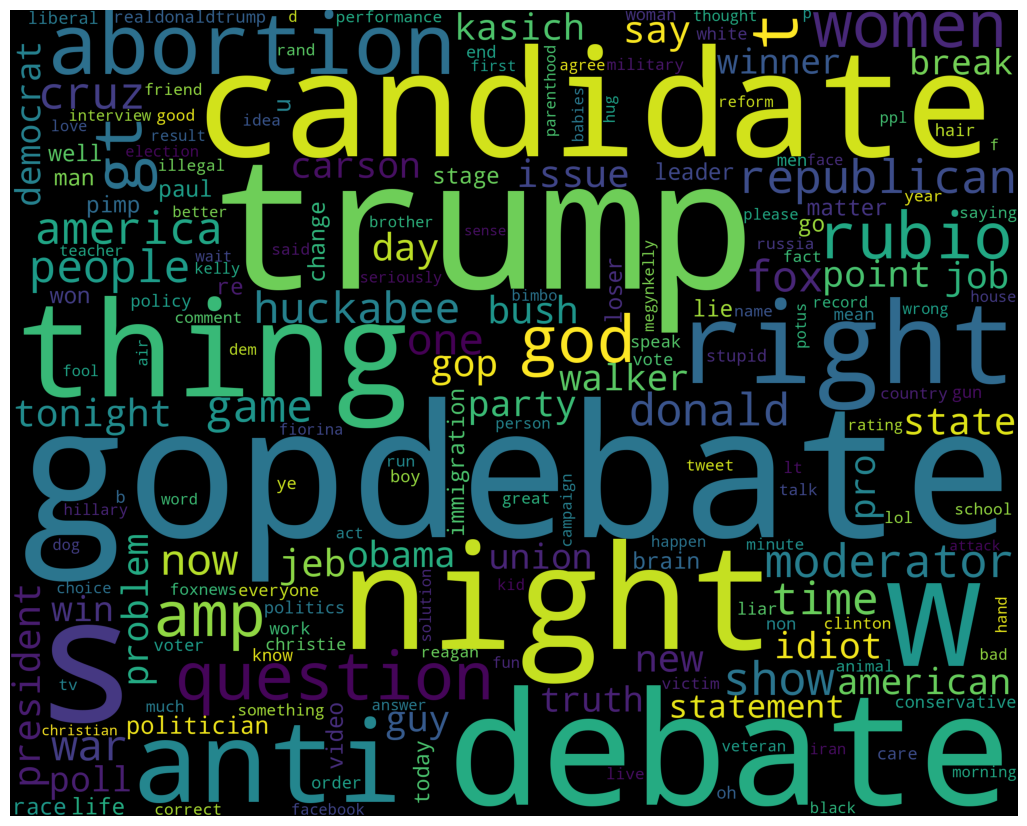

In [ ]:
w_features = get_word_features(get_words_in_tweets(tweets))
wordcloud_draw(w_features)

In [ ]:
training_set_tfidf = [extract_features_tfidf_pca(tweet) for tweet in tweets]
training_set_word_features = [transform_to_word_features(features_dict) for features_dict in training_set_tfidf]
training_set_word_features_tuples = [(features_dict, features_dict['sentiment']) for features_dict in training_set_word_features]
training_set_word_features_tuples[0]

({'contains(anyone)': 0.31622776601683794,
  'contains(chris)': 0.31622776601683794,
  'contains(does)': 0.31622776601683794,
  'contains(else)': 0.31622776601683794,
  'contains(face)': 0.31622776601683794,
  'contains(just)': 0.31622776601683794,
  'contains(punch)': 0.31622776601683794,
  'contains(the)': 0.31622776601683794,
  'contains(wallace)': 0.31622776601683794,
  'contains(want)': 0.31622776601683794,
  'sentiment': 'Negative'},
 'Negative')

In [ ]:
classifier5 = nltk.NaiveBayesClassifier.train(training_set_word_features_tuples)

In [ ]:
test_tweets = []
for index, row in test.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    test_tweets.append((words_cleaned,row.sentiment))
test_set_tfidf = [extract_features_tfidf_pca(tweet) for tweet in test_tweets]
test_set_word_features = [transform_to_word_features(features_dict) for features_dict in test_set_tfidf]
test_set_word_features_tuples = [(features_dict, features_dict['sentiment']) for features_dict in test_set_word_features]
test_set_word_features[0]

{'contains(16)': 0.23570226039551587,
 'contains(all)': 0.23570226039551587,
 'contains(america)': 0.23570226039551587,
 'contains(every)': 0.23570226039551587,
 'contains(for)': 0.23570226039551587,
 'contains(household)': 0.23570226039551587,
 'contains(hungry)': 0.23570226039551587,
 'contains(ideas)': 0.23570226039551587,
 'contains(last)': 0.23570226039551587,
 'contains(new)': 0.23570226039551587,
 'contains(night)': 0.23570226039551587,
 'contains(overnights)': 0.23570226039551587,
 'contains(record)': 0.23570226039551587,
 'contains(show)': 0.23570226039551587,
 'contains(time)': 0.23570226039551587,
 'contains(watched)': 0.23570226039551587,
 'sentiment': 'Negative'}

In [ ]:
correct = 0
total = 0
for test in test_set_word_features:
    prediction = classifier5.classify(test)
    if prediction == test['sentiment']:
        correct += 1
    total += 1

accuracy = correct / total
print("Accuracy:", accuracy)

Accuracy: 0.7820759250360404
